In [1]:
import pandas as pd
import textdistance

from ssrq_retro_lab.config import PROJECT_ROOT
from ssrq_retro_lab.repository import reader

In [2]:
import json

txt_pdf_conversion_table = json.loads(
    reader.TextReader((PROJECT_ROOT / "data/ZG/txt_to_pdf.json")).read()
)

In [3]:
from fitz_new import Document
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import namedtuple

ErrorRate = namedtuple("ErrorRate", ["cer", "similarity"])

def get_page_text_from_pdf(pdf: Document, page: int) -> str:
    return pdf.load_page(page).get_textpage().extractText(sort=True)

def calc_error_rate(master: str, page: str) -> ErrorRate:
    cer = textdistance.levenshtein.normalized_distance(master, page) * 100
    vectorizer = CountVectorizer()

    bag_of_words = vectorizer.fit_transform([master, page])

    similarity = cosine_similarity(bag_of_words[0:1], bag_of_words[1:2])

    return ErrorRate(cer, similarity[0][0])

In [4]:
volumes = [pdf for pdf in (PROJECT_ROOT / "data/ZG/pdf").glob("*.pdf")]
master_transcriptions = [txt for txt in (PROJECT_ROOT / "data/ZG/master").glob("*.txt")]

TranscriptInfo = namedtuple("TranscriptInfo", ["name", "page_number", "volume", "cer", "cosine_similarity"])

results: list[TranscriptInfo] = []

for volume in volumes:
    doc = reader.PDFReader(volume).read()
    volume_name = volume.name.removesuffix(".pdf").replace(".", "_")
    transcriptions = [
        transcription
        for transcription in master_transcriptions
        if transcription.name.startswith(volume_name)
    ]

    for transcription in transcriptions:
        page_number = int(
                txt_pdf_conversion_table[volume_name][
                    transcription.name.removesuffix(".txt")
                ]
            )
        page_text = get_page_text_from_pdf(
            doc,
            page_number,
        )
        master_text = reader.TextReader(transcription).read()
        results.append(
            TranscriptInfo(
                transcription.name.removesuffix(".txt"),
                page_number,
                volume_name,
                *calc_error_rate(master_text, page_text)
            )
        )

df = pd.DataFrame(results)
df

,name,page_number,volume,cer,cosine_similarity
0,ZG_1_1_10,387,ZG_1_1,2.415660,0.998088
1,ZG_1_1_11,388,ZG_1_1,2.830734,0.982301
2,ZG_1_1_13,437,ZG_1_1,2.335709,0.993726
3,ZG_1_1_12,418,ZG_1_1,3.288490,0.984337
4,ZG_1_1_8,385,ZG_1_1,2.182453,0.994351
5,ZG_1_1_9,386,ZG_1_1,2.552491,0.998155
6,ZG_1_1_15,606,ZG_1_1,2.816901,0.990826
7,ZG_1_1_14,466,ZG_1_1,2.302632,0.996708
8,ZG_1_1_7,380,ZG_1_1,2.636204,0.994389
9,ZG_1_1_6,126,ZG_1_1,4.043752,0.981815


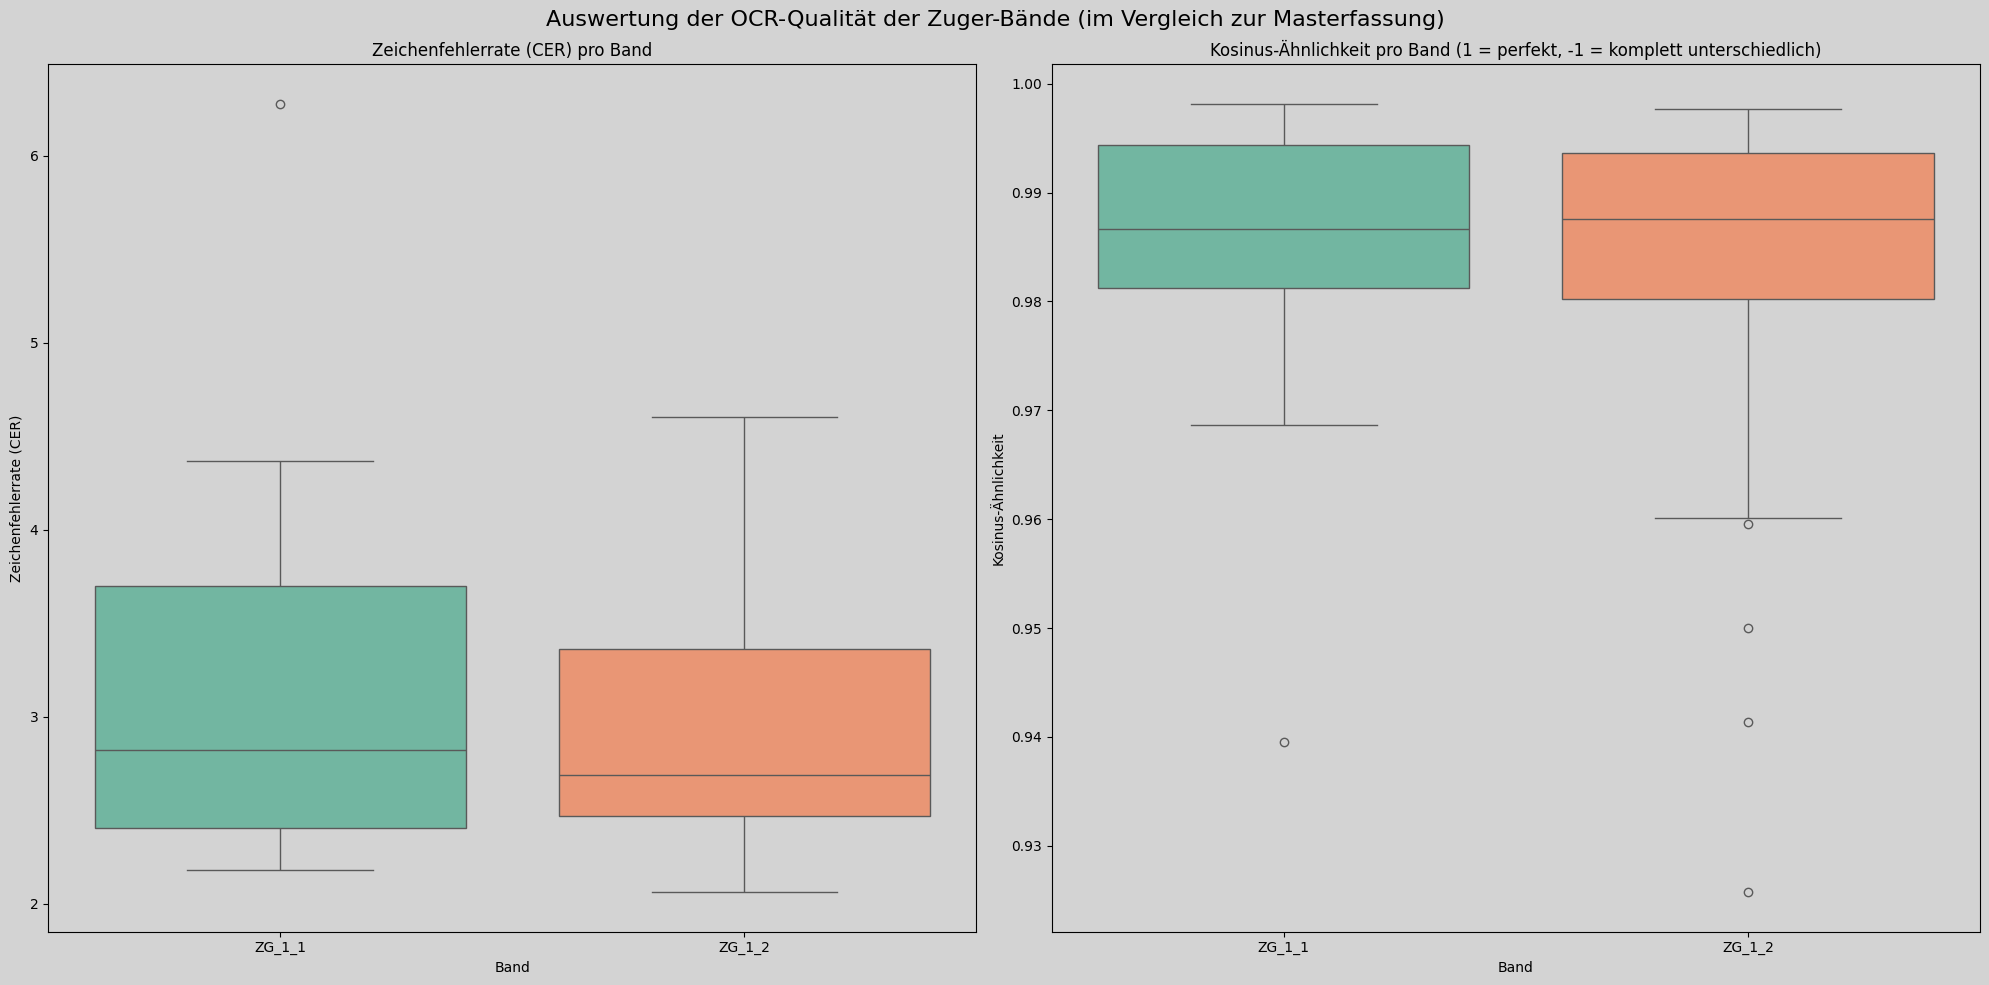

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
fig.set_facecolor('lightgray')
plot_one = sns.boxplot(x='volume', y='cer', data=df, ax=ax[0], palette='Set2', hue='volume')
plot_one.set_xlabel('Band')
plot_one.set_ylabel('Zeichenfehlerrate (CER)')
plot_one.set_facecolor('lightgray')
ax[0].set_title('Zeichenfehlerrate (CER) pro Band', fontsize=12)

plot_two = sns.boxplot(x='volume', y='cosine_similarity', data=df, ax=ax[1], palette='Set2', hue='volume')
plot_two.set_xlabel('Band')
plot_two.set_ylabel('Kosinus-Ähnlichkeit')
plot_two.set_facecolor('lightgray')
ax[1].set_title('Kosinus-Ähnlichkeit pro Band (1 = perfekt, -1 = komplett unterschiedlich)', fontsize=12)

fig.suptitle('Auswertung der OCR-Qualität der Zuger-Bände (im Vergleich zur Masterfassung)', fontsize=16)

plt.tight_layout()
plt.show()

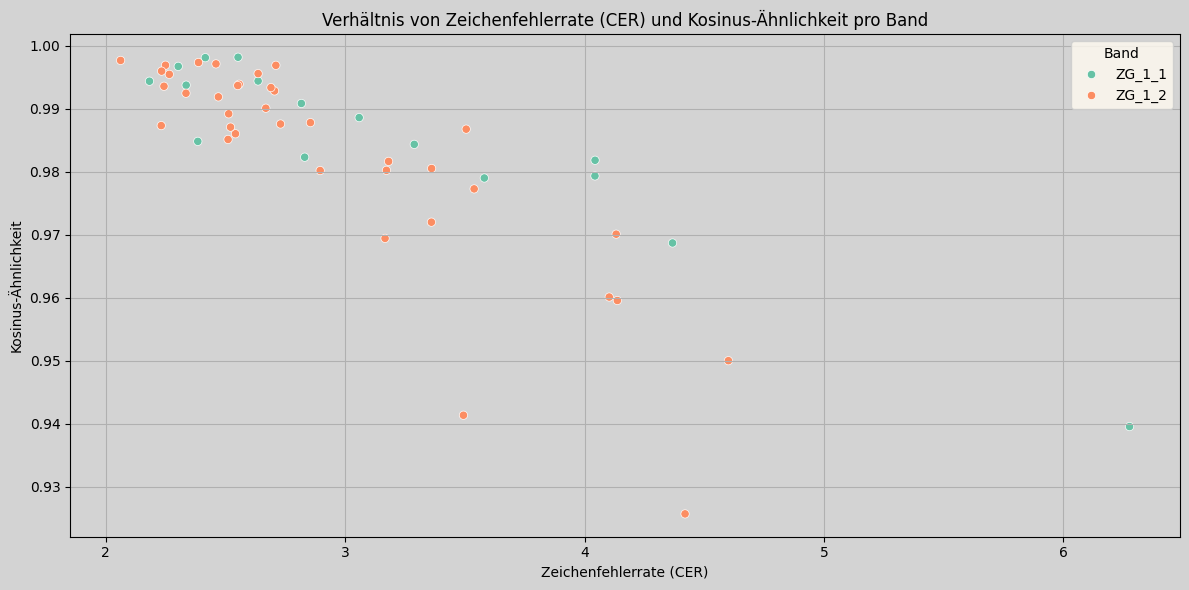

In [6]:
plt.figure(figsize=(12, 6), facecolor='lightgray')
plot = sns.scatterplot(data=df, x='cer', y='cosine_similarity', hue='volume', palette='Set2')
plot.set_facecolor('lightgray')
plt.title('Verhältnis von Zeichenfehlerrate (CER) und Kosinus-Ähnlichkeit pro Band')
plt.xlabel('Zeichenfehlerrate (CER)')
plt.ylabel('Kosinus-Ähnlichkeit')
plt.legend(title='Band', facecolor='floralwhite')
plt.grid(True)
plt.tight_layout()

plt.show()


In [9]:
doc = reader.PDFReader(volumes[0]).read()
print(get_page_text_from_pdf(doc,418))


E. Staatswesen • 572-583
377
StAZürich A 259.4. -  1767 Juni 1. Personalien (Signalement) des alt Statthalter 
Brandenberg, seines Sohnes und Tochtersohnes, samt beigefügter Nachricht, daß Zug 
gezwungen war, sein Stadt- und Amt-Sekret zu ändern, ebd.
1787 März 10.
580. Pflicht, Käufe der Kanzlei anzumelden
KAZug, Th. 87, VI. B. 2. -1787 Mai 4. Kaufverträge müssen vom geschworenen 
Schreiber beurkundet werden. StAZug, StaR 42, 374. -  1787 Mai 14. Die Stadt Zug 
genehmigt die Bestimmung, Aegeri verwirft sie, Menzingen verwirft und protestiert. 
StAR 42, 376f.
io y) Der Stadt- und Amtrat 
1546 Februar 10.
581. Aufforderung des Stadt- und Amtsrates an die Weibel zur Erfüllung 
ihrer Pflichten, Einfangen von Schuldigen, Pfändungen.
KAZug, Th. 87, VI. B. 2. 
is  
(Ca 1580)
582. Amtsgeheimnis. Weibelpflicht
[1] Ittem  mine herren statt und ampts habend mit einandern uff 
und angenommen: Welcher der were und nun fürohin uß dem rath 
vill oder wenig reden oder schwetzen wurde, das der selbig 